In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [34]:
df = pd.read_csv('taxi_trip_pricing.csv')

In [35]:
df.head()

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,Weekday,3.0,Low,Clear,3.56,0.80,0.32,53.82,36.2624
1,47.59,Afternoon,Weekday,1.0,High,Clear,NaN,0.62,0.43,40.57,NaN
2,36.87,Evening,Weekend,1.0,High,Clear,2.70,1.21,0.15,37.27,52.9032
3,30.33,Evening,Weekday,4.0,Low,NaN,3.48,0.51,0.15,116.81,36.4698
4,NaN,Evening,Weekday,3.0,High,Clear,2.93,0.63,0.32,22.64,15.6180


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       950 non-null    float64
 1   Time_of_Day            950 non-null    object 
 2   Day_of_Week            950 non-null    object 
 3   Passenger_Count        950 non-null    float64
 4   Traffic_Conditions     950 non-null    object 
 5   Weather                950 non-null    object 
 6   Base_Fare              950 non-null    float64
 7   Per_Km_Rate            950 non-null    float64
 8   Per_Minute_Rate        950 non-null    float64
 9   Trip_Duration_Minutes  950 non-null    float64
 10  Trip_Price             951 non-null    float64
dtypes: float64(7), object(4)
memory usage: 86.1+ KB


In [37]:
df.describe()

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
count,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,951.000000
mean,27.070547,2.476842,3.502989,1.233316,0.292916,62.118116,56.874773
std,19.905300,1.102249,0.870162,0.429816,0.115592,32.154406,40.469791
min,1.230000,1.000000,2.010000,0.500000,0.100000,5.010000,6.126900
25%,12.632500,1.250000,2.730000,0.860000,0.190000,35.882500,33.742650
50%,25.830000,2.000000,3.520000,1.220000,0.290000,61.860000,50.074500
75%,38.405000,3.000000,4.260000,1.610000,0.390000,89.055000,69.099350
max,146.067047,4.000000,5.000000,2.000000,0.500000,119.840000,332.043689


In [38]:
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")


Number of duplicate rows: 0


In [39]:
print("\nNull values in each column:")
print(df.isnull().sum())


Null values in each column:
Trip_Distance_km         50
Time_of_Day              50
Day_of_Week              50
Passenger_Count          50
Traffic_Conditions       50
Weather                  50
Base_Fare                50
Per_Km_Rate              50
Per_Minute_Rate          50
Trip_Duration_Minutes    50
Trip_Price               49
dtype: int64


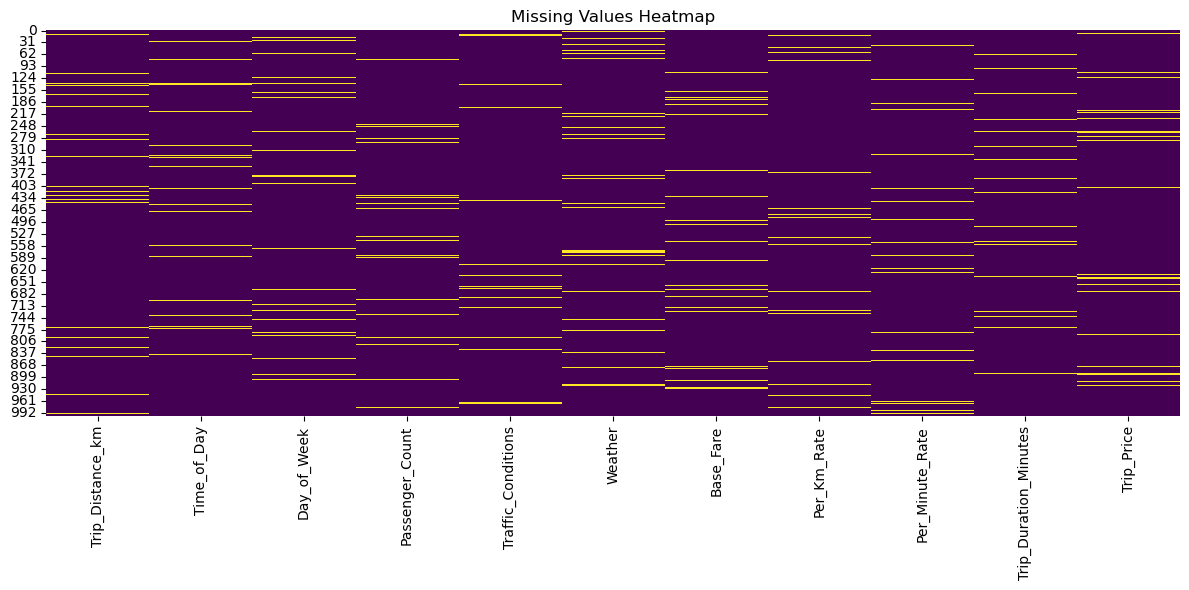

In [40]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.tight_layout()
plt.show()

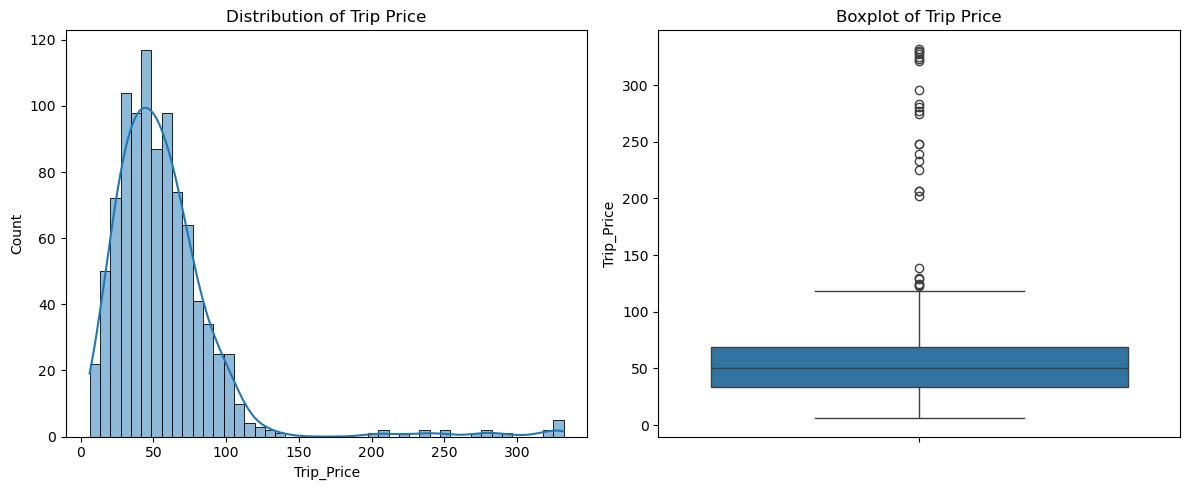

In [41]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['Trip_Price'].dropna(), kde=True)
plt.title('Distribution of Trip Price')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['Trip_Price'])
plt.title('Boxplot of Trip Price')

plt.tight_layout()
plt.show()

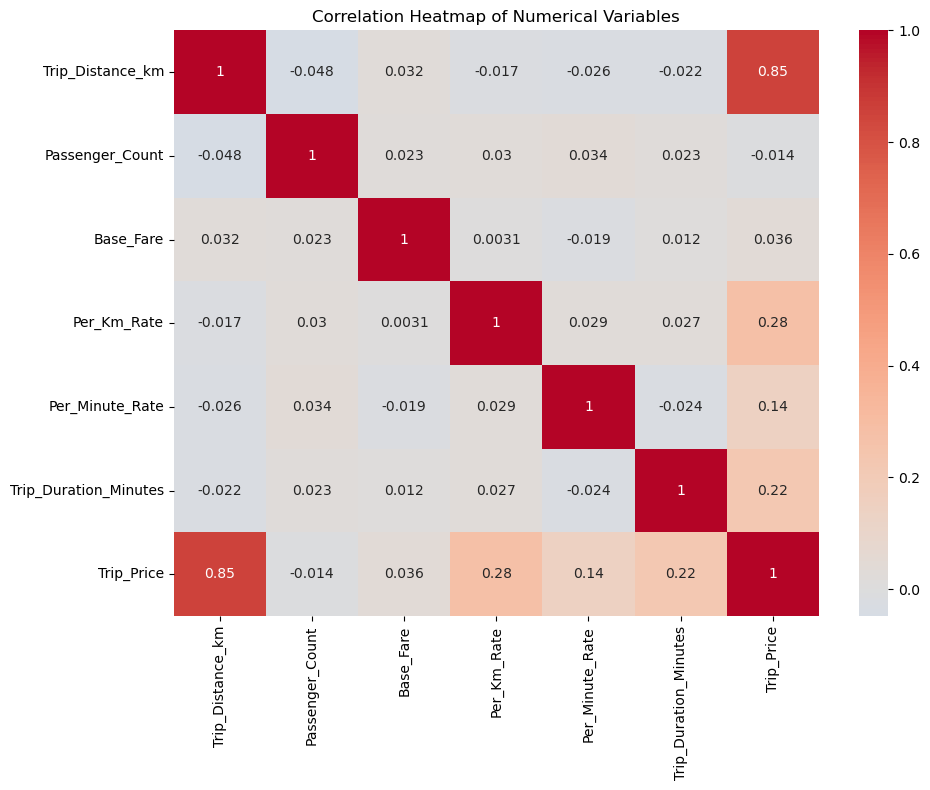

In [42]:
numerical_cols = ['Trip_Distance_km', 'Passenger_Count', 'Base_Fare', 'Per_Km_Rate', 
                 'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Price']

plt.figure(figsize=(10, 8))
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Numerical Variables')
plt.tight_layout()
plt.show()

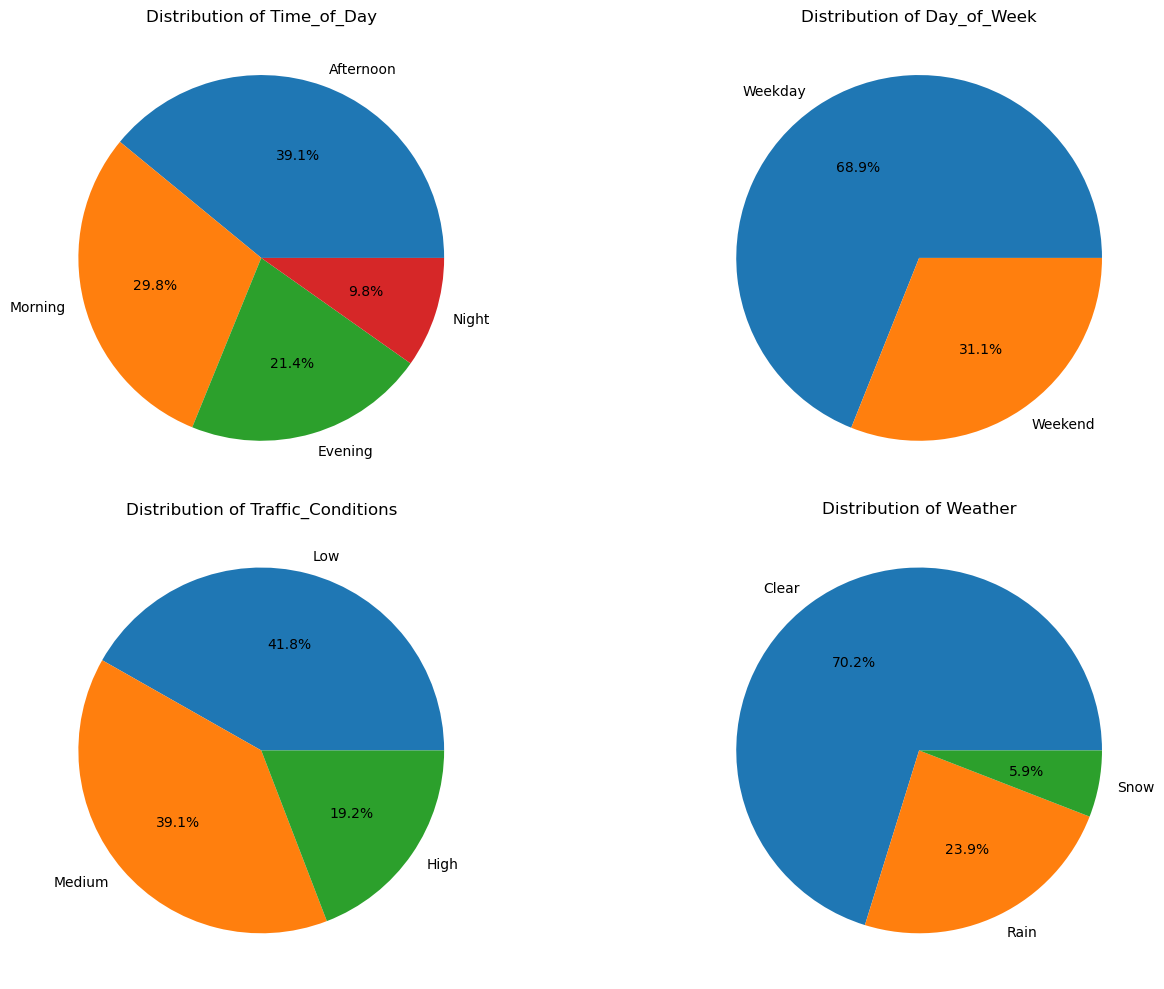

In [43]:
categorical_cols = ['Time_of_Day', 'Day_of_Week', 'Traffic_Conditions', 'Weather']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    if col in df.columns:
        value_counts = df[col].value_counts()
        axes[i].pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%')
        axes[i].set_title(f'Distribution of {col}')
    else:
        axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [44]:
features = ['Trip_Distance_km', 'Time_of_Day', 'Day_of_Week', 'Passenger_Count',
           'Traffic_Conditions', 'Weather', 'Base_Fare', 'Per_Km_Rate',
           'Per_Minute_Rate', 'Trip_Duration_Minutes']

target = 'Trip_Price'

In [45]:
df_model = df.copy()

df_model = pd.get_dummies(df_model, columns=['Time_of_Day', 'Day_of_Week', 
                                           'Traffic_Conditions', 'Weather'], 
                         drop_first=True)

In [46]:
# Update features list to include dummy variables

all_features = [col for col in df_model.columns if col != target and col in df_model.columns]

In [47]:
X = df_model[all_features]
y = df_model[target]

In [48]:
# Handle missing values
imputer_X = SimpleImputer(strategy='mean')
imputer_y = SimpleImputer(strategy='mean')

X_imputed = imputer_X.fit_transform(X)
y_imputed = imputer_y.fit_transform(y.values.reshape(-1, 1)).ravel()

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y_imputed, test_size=0.2, random_state=42
)

In [50]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 800
Test set size: 200


In [51]:
svm_model = SVR(kernel='rbf', C=16.0, epsilon=1.2)
svm_model.fit(X_train_scaled, y_train)

SVR(C=16.0, epsilon=1.2)

In [52]:
y_pred = svm_model.predict(X_test_scaled)

In [53]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [54]:
mse

174.91078218521636

In [55]:
rmse

13.225384008988788

In [56]:
r2

0.7893565065737513

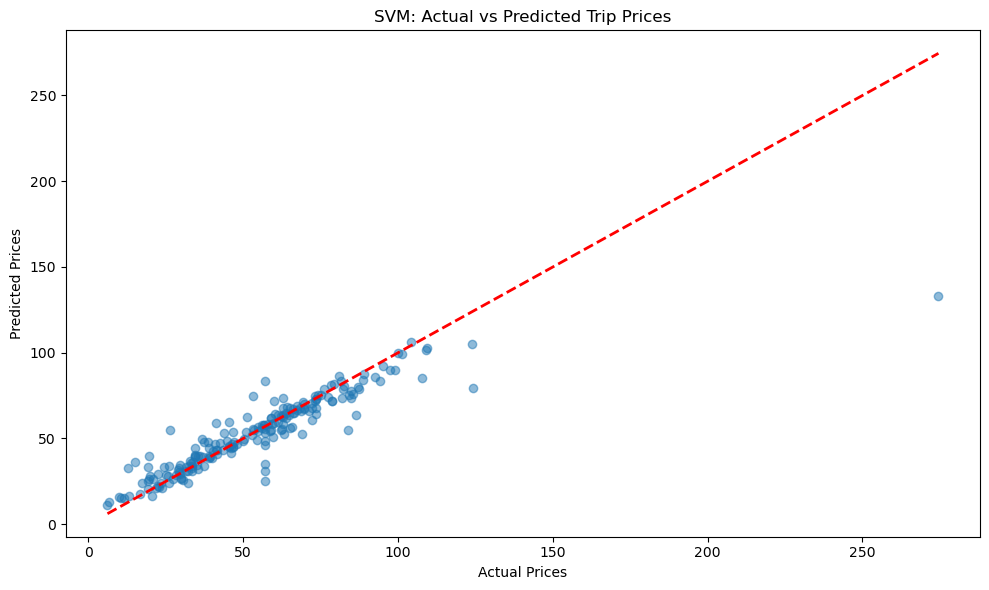

In [57]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('SVM: Actual vs Predicted Trip Prices')
plt.tight_layout()
plt.show()

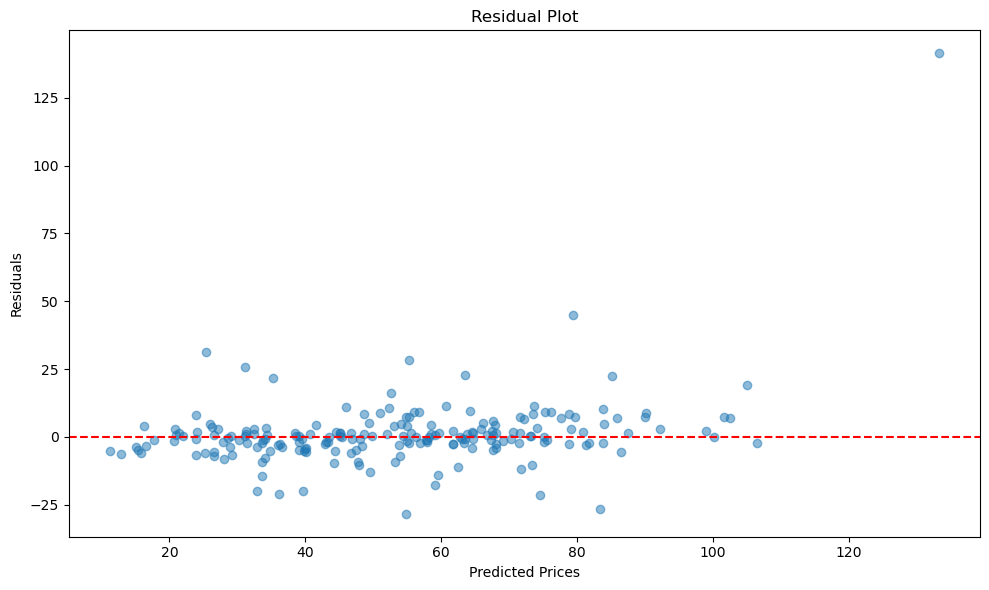

In [58]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()